# Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

### Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import shutil
from collections import Counter
import random
from tensorflow import keras
from keras import layers
import numpy as np
from pathlib import Path

### 1.Obtain the Data: Get the Dogs vs Cats dataset 

Here we are extracting the data from the data set and converting the large data set(25000) into small data set (5000 Images)

In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path("Train")
new_base_dir = pathlib.Path("new_dataset_cat_dog")

def make_subset(subset_name, start_index, end_index):
    for category in ("Cat", "Dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir/fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### 2.EDA: Explore the data with relevant graphs, statistics and insights 

#### 2.1.Class Distribution

To determine whether the data is balanced or skewed, plot the number of photos in each class (dogs vs. cats).

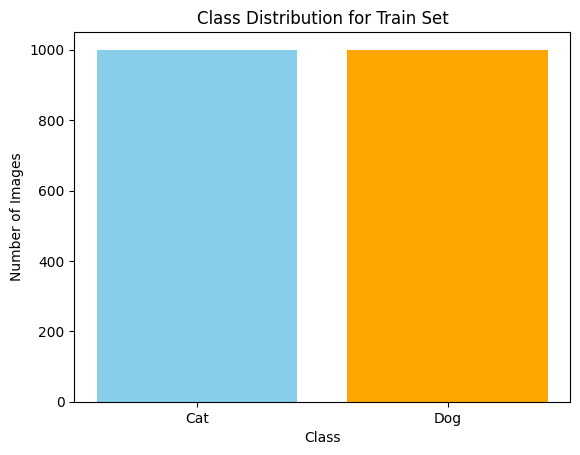

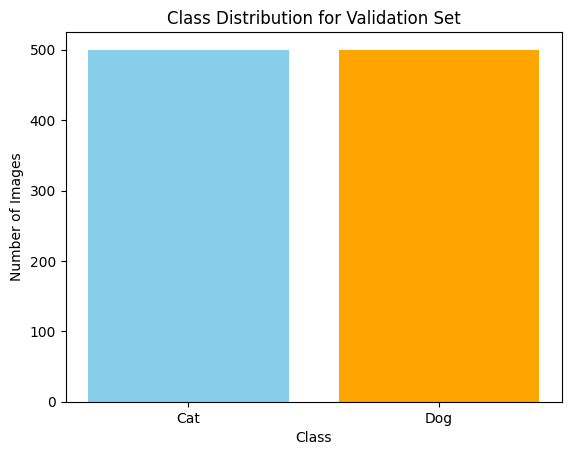

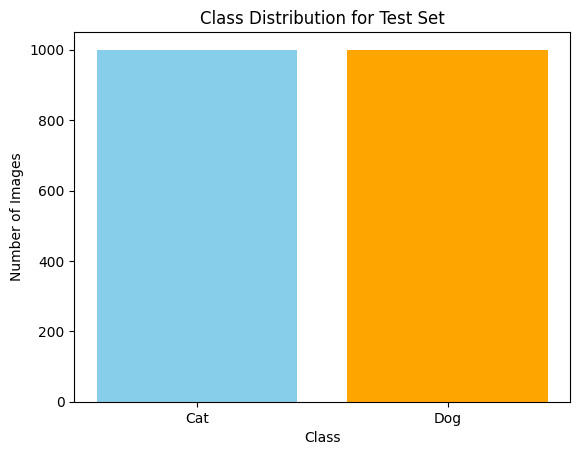

In [3]:
new_base_dir = pathlib.Path("new_dataset_cat_dog")

def plot_class_distribution(base_dir):
    subsets = ["train", "validation", "test"]
    for subset in subsets:
        subset_dir = base_dir / subset
        counts = Counter()
        for category_dir in subset_dir.iterdir():
            if category_dir.is_dir():
                counts[category_dir.name] = len(list(category_dir.glob("*.jpg")))
        
        # Plot the distribution
        categories = list(counts.keys())
        values = list(counts.values())
        plt.bar(categories, values, color=['skyblue', 'orange'])
        plt.title(f"Class Distribution for {subset.capitalize()} Set")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.show()

plot_class_distribution(new_base_dir)

#### Statistical Insights 

* The representation of the "Cat" and "Dog" classes is almost identical for each of the subsets (train, validation, and test).

* Because it guarantees that the model is not biased toward one class over another, this balance is advantageous for model training. Poor generalization might result from the model being unduly focused on the dominant class due to imbalanced datasets.

* **Distribution of Classes for Test, Validation, and Train Sets:**

* **Training Set:** The most pictures, which make up the bulk of the data used to train the model. The model can learn a variety of features from both classes with the aid of a well-balanced training set.

* **Validation Set:** A more condensed but evenly distributed collection of photos used to confirm how well the model performed during training. This set aids in model refinement and guards against overfitting.

* **Test Set:** Equally balanced, offering an objective assessment of the model's functionality on unobserved data.

#### 2.2.Sample Images

To gain a sense of the dataset visual style, we are displaying few pictures from each class.


Statistics for Train Set:
  Cat: 1000
  Dog: 1000


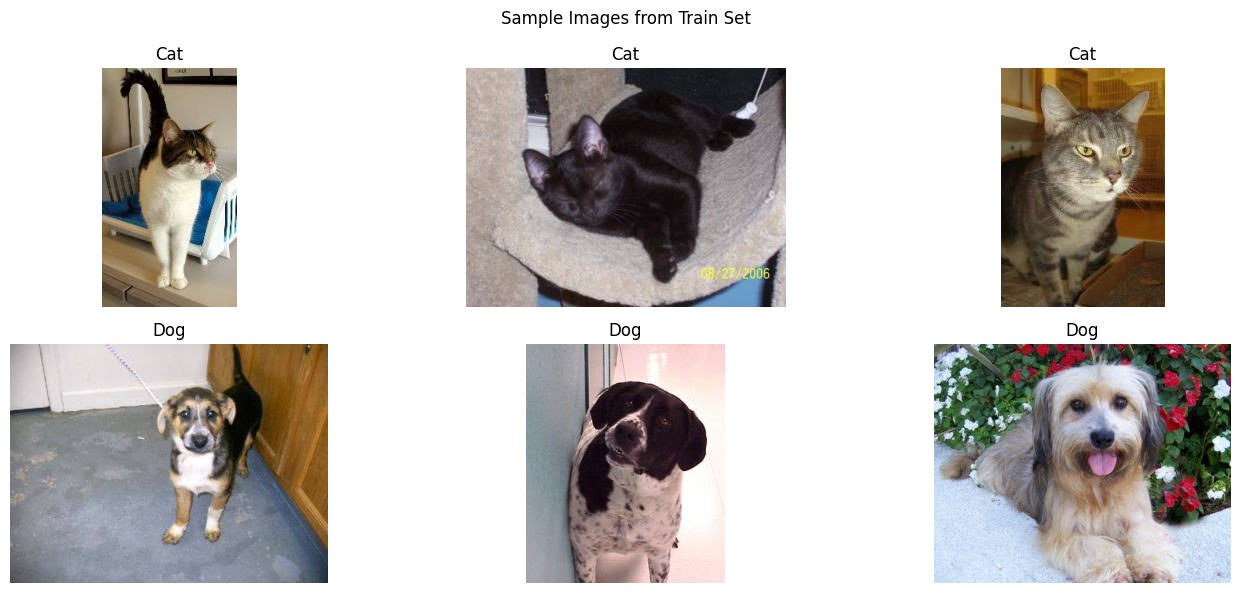


Statistics for Validation Set:
  Cat: 500
  Dog: 500


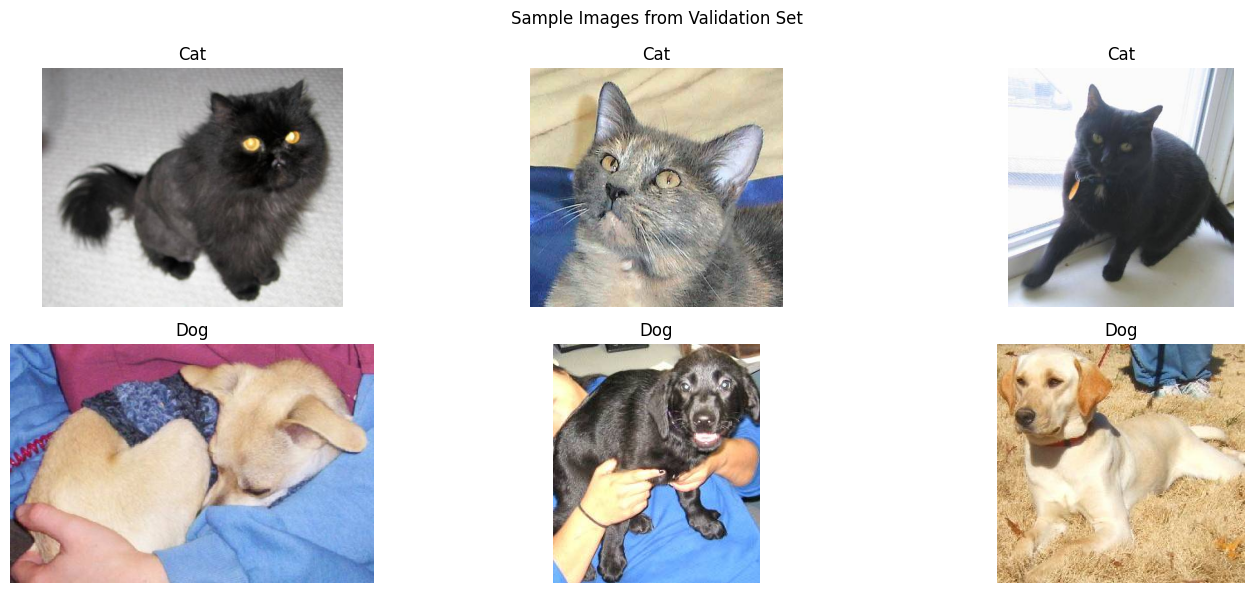


Statistics for Test Set:
  Cat: 1000
  Dog: 1000


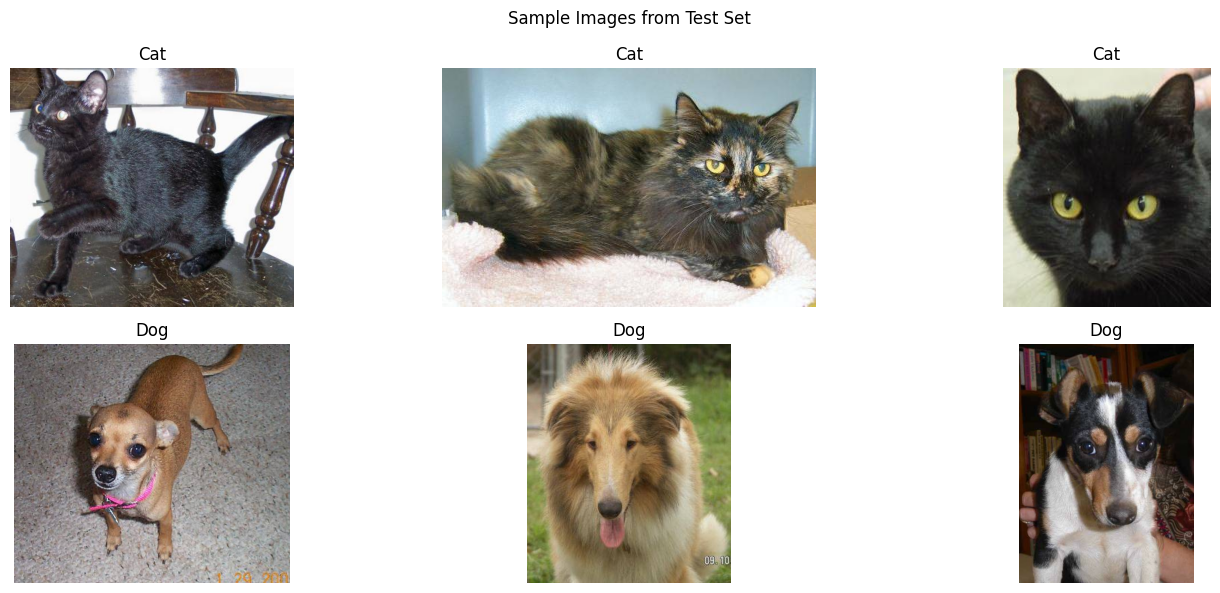

In [4]:
def analyze_and_display(base_dir, num_samples=3):
    subsets = ["train", "validation", "test"]
    for subset in subsets:
        subset_dir = base_dir / subset
        counts = Counter()
        
        # Count the images for each category
        for category_dir in subset_dir.iterdir():
            if category_dir.is_dir():
                counts[category_dir.name] = len(list(category_dir.glob("*.jpg")))
        
        # Display statistics
        print(f"\nStatistics for {subset.capitalize()} Set:")
        for category, count in counts.items():
            print(f"  {category}: {count}")
        
        # Display sample images
        fig, axes = plt.subplots(len(counts), num_samples, figsize=(15, 6))
        categories = list(counts.keys())
        
        for i, category in enumerate(categories):
            category_dir = subset_dir / category
            images = list(category_dir.glob("*.jpg"))
            sample_images = random.sample(images, min(num_samples, len(images)))
            
            for j, image_path in enumerate(sample_images):
                img = Image.open(image_path)
                if len(categories) > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[j]  # For cases where there's only one row
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"{category}")
        
        plt.suptitle(f"Sample Images from {subset.capitalize()} Set")
        plt.tight_layout()
        plt.show()

# Analyze and display data for all subsets
analyze_and_display(new_base_dir)

#### Statistical Insights :

1. **Balanced Dataset:**

* There are exactly equal numbers of photos for cats and dogs in each collection (train, validation, and test). By maintaining this balance, the model is guaranteed to treat all classes equally during training and assessment and not to be prejudiced against one.

2. **Big Training Data:**

* There are a significant number of photos (2,000 total) in the training set. This gives the model a strong basis on which to learn and generalize.

* Model performance on unseen data is enhanced and overfitting is lessened with a well-balanced and sizable training dataset.

3. **Sufficient Data for Validation and Testing:**

* There are 1,000 photos in the validation set. This is perfect for tracking model performance while training (e.g., early halting and hyperparameter adjustment).

* With 2,000 photos, the test set offers a solid foundation for assessing the model's precision and generalization to new data.

4. **Diversity of Class:**

* Based on the sample photos, it appears that a variety of dog and cat breeds, colors, and positions are represented. The model's capacity to generalize to actual situations is enhanced by this diversity.

* The dataset is robust because it includes a variety of backdrops, lighting situations, and orientations (such as close-ups, sitting, and lying down).

5. **Completeness of the dataset:**

* The dataset size is appropriate for training a deep learning model, like a convolutional neural network (CNN), with 5,000 photos overall across all subgroups. It is not too big (manageable within computing bounds) or too little (prone to underfitting).

#### 2.3.Image Size Analysis

To determine whether resizing is required and to spot any irregularities, compile statistics on image dimensions.


Image Size Analysis and Distribution for Train Set:
  Total Images: 2000
  Min Width: 59
  Max Width: 1023
  Mean Width: 403.9725
  Mode Width: 499
  Min Height: 50
  Max Height: 768
  Mean Height: 358.9175
  Mode Height: 374


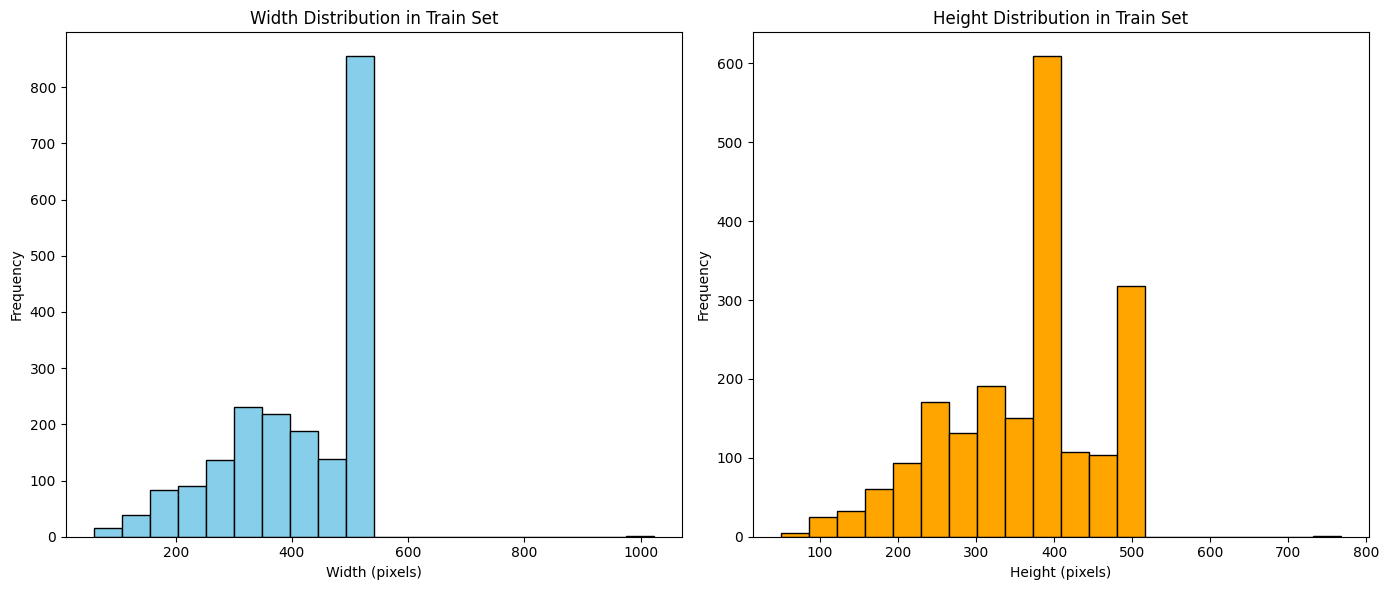


Image Size Analysis and Distribution for Validation Set:
  Total Images: 1000
  Min Width: 59
  Max Width: 500
  Mean Width: 407.214
  Mode Width: 499
  Min Height: 45
  Max Height: 500
  Mean Height: 365.296
  Mode Height: 375


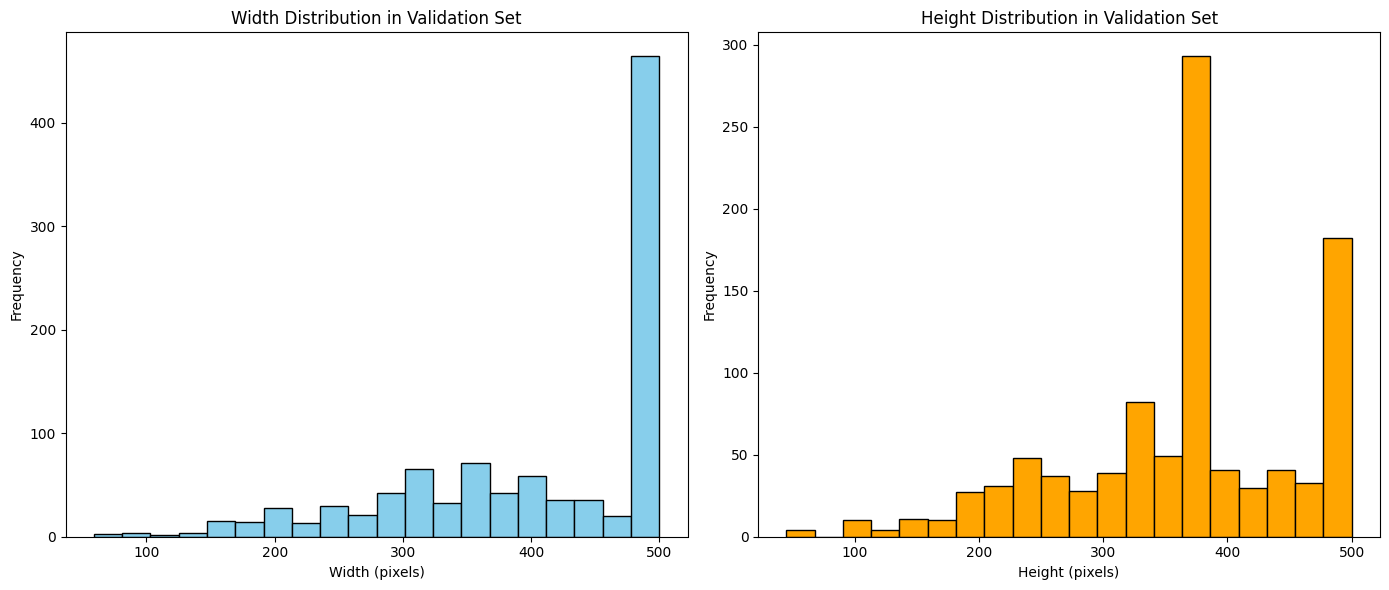


Image Size Analysis and Distribution for Test Set:
  Total Images: 2000
  Min Width: 59
  Max Width: 1050
  Mean Width: 402.127
  Mode Width: 499
  Min Height: 41
  Max Height: 702
  Mean Height: 359.846
  Mode Height: 374


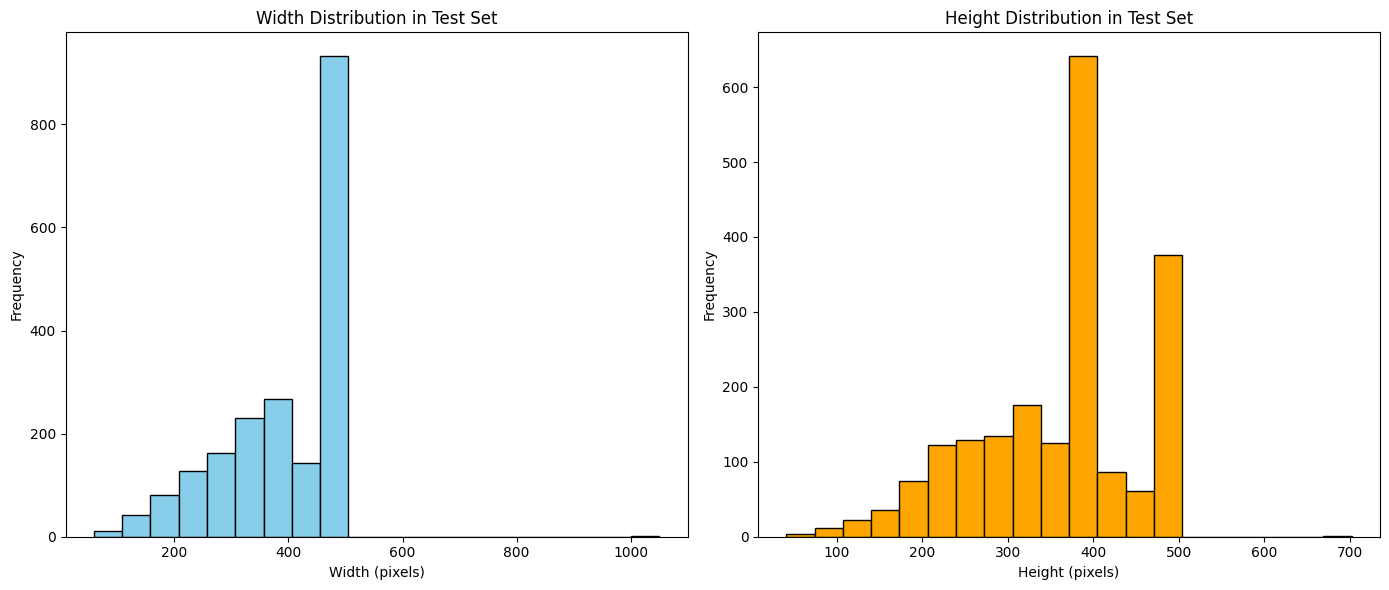

In [5]:
def analyze_and_plot_image_sizes(base_dir):
    subsets = ["train", "validation", "test"]
    
    for subset in subsets:
        subset_dir = base_dir / subset
        print(f"\nImage Size Analysis and Distribution for {subset.capitalize()} Set:")
        
        # Collect dimensions
        widths = []
        heights = []
        for category_dir in subset_dir.iterdir():
            if category_dir.is_dir():
                for image_path in category_dir.glob("*.jpg"):
                    with Image.open(image_path) as img:
                        width, height = img.size
                        widths.append(width)
                        heights.append(height)
        
        # Calculate statistics
        stats = {
            "Total Images": len(widths),
            "Min Width": np.min(widths),
            "Max Width": np.max(widths),
            "Mean Width": np.mean(widths),
            "Mode Width": Counter(widths).most_common(1)[0][0],
            "Min Height": np.min(heights),
            "Max Height": np.max(heights),
            "Mean Height": np.mean(heights),
            "Mode Height": Counter(heights).most_common(1)[0][0],
        }
        
        # Display statistics
        for key, value in stats.items():
            print(f"  {key}: {value}")
        
        # Plot width and height distributions
        plt.figure(figsize=(14, 6))
        
        # Width distribution
        plt.subplot(1, 2, 1)
        plt.hist(widths, bins=20, color='skyblue', edgecolor='black')
        plt.title(f"Width Distribution in {subset.capitalize()} Set")
        plt.xlabel("Width (pixels)")
        plt.ylabel("Frequency")
        
        # Height distribution
        plt.subplot(1, 2, 2)
        plt.hist(heights, bins=20, color='orange', edgecolor='black')
        plt.title(f"Height Distribution in {subset.capitalize()} Set")
        plt.xlabel("Height (pixels)")
        plt.ylabel("Frequency")
        
        plt.tight_layout()
        plt.show()

# Analyze and plot for all subsets
analyze_and_plot_image_sizes(new_base_dir)

#### Statistical Insights :

* The dataset includes 1000 photos in the validation set and 2000 images in the train and test sets. In machine learning, the ratio of the training and validation/test sets is usually 2:1.

* With a mean width of about 400 pixels, the images in the training set (and test set) range in width from 59 pixels to 1023 pixels and 1050 pixels, respectively. The setting indicates that the majority of photos are 499 pixels wide. The height ranges from 41 to 59 pixels at the least and from 500 to 768 pixels at the maximum. The majority of photos are between 374 and 375 pixels high, with a typical height of 358 to 365 pixels.

* There are very slight differences in the maximum values of the width and height distributions between the train, validation, and test groups. Nonetheless, the existence of both extremely small and huge images points to the necessity of preprocessing. To guarantee that there is enough detail for model training, images of smaller dimensions (41–59 pixels) should probably be enlarged. However, in order to prevent memory and computational problems, photos with greater dimensions (such as 1023–1050 pixels) would need to be shrunk.

* Resizing every image to a uniform size, such 224x224 pixels, or using data augmentation methods like cropping, scaling, and rotation to strengthen the model against size variations are two possible approaches to managing the image size variance. The photographs' aspect ratios should also be examined for consistency, and any necessary alterations (such cropping or padding) may be needed to guarantee consistency throughout the collection.

#### 2.4.Image Intensity Distribution

To comprehend the lighting and contrast in the pictures, plot the distribution of pixel intensity.


Analyzing Intensity Distribution for Train Set...
Total Pixels: 301004325
Min Intensity: 0
Max Intensity: 255
Mean Intensity: 116.13
Std Dev Intensity: 0.00


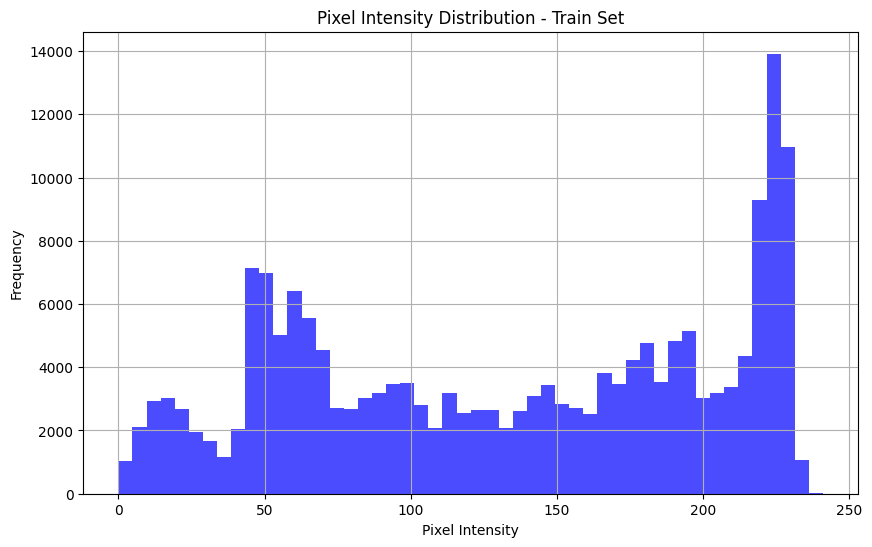


Analyzing Intensity Distribution for Validation Set...
Total Pixels: 153881168
Min Intensity: 0
Max Intensity: 255
Mean Intensity: 117.15
Std Dev Intensity: 0.00


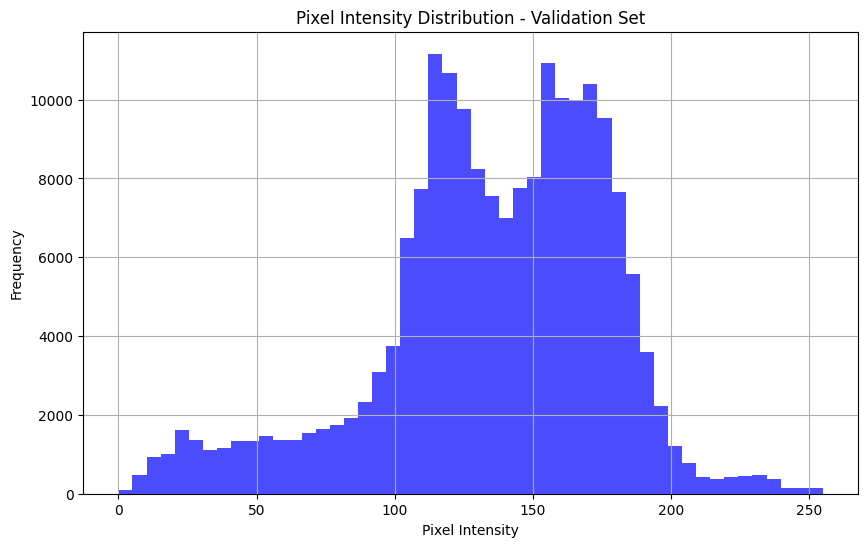


Analyzing Intensity Distribution for Test Set...
Total Pixels: 300450092
Min Intensity: 0
Max Intensity: 255
Mean Intensity: 117.23
Std Dev Intensity: 0.00


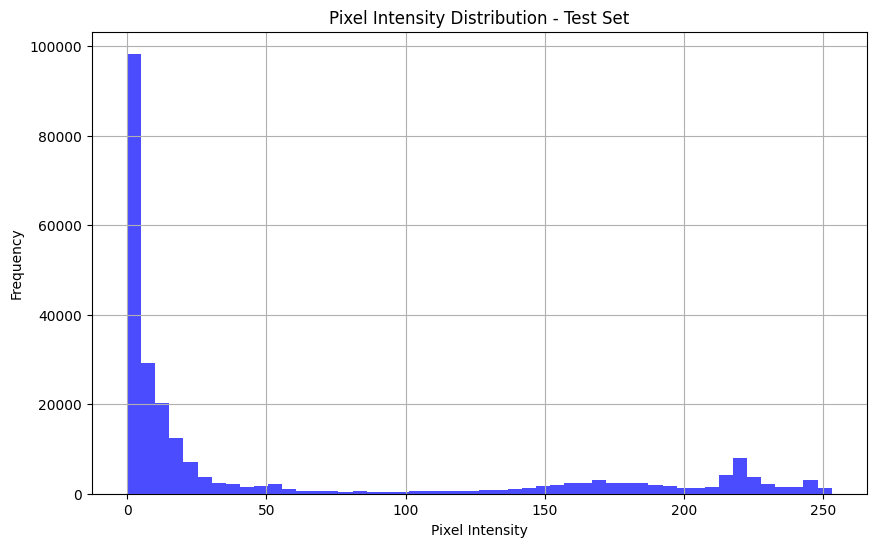

In [ ]:


def analyze_and_plot_intensity_distribution(base_dir):
    subsets = ["train", "validation", "test"]
    for subset in subsets:
        print(f"\nAnalyzing Intensity Distribution for {subset.capitalize()} Set...")
        subset_dir = Path(base_dir) / subset

        stats = {
            "Total Pixels": 0,
            "Sum Intensities": 0,
            "Sum Squared Intensities": 0,
            "Min Intensity": float("inf"),
            "Max Intensity": float("-inf"),
        }

        intensities_sample = []  # Collect a sample for plotting (not all)

        for category_dir in subset_dir.iterdir():
            if category_dir.is_dir():
                for image_path in category_dir.glob("*.jpg"):
                    with Image.open(image_path).convert("L") as img:  # Convert to grayscale
                        intensity_array = np.array(img)
                        stats["Total Pixels"] += intensity_array.size
                        stats["Sum Intensities"] += intensity_array.sum()
                        stats["Sum Squared Intensities"] += (intensity_array ** 2).sum()
                        stats["Min Intensity"] = min(stats["Min Intensity"], intensity_array.min())
                        stats["Max Intensity"] = max(stats["Max Intensity"], intensity_array.max())

                        # Collect sample for plotting
                        if len(intensities_sample) < 100000:  # Limit sample size for memory efficiency
                            intensities_sample.extend(intensity_array.flatten())

        # Compute mean and standard deviation
        mean_intensity = stats["Sum Intensities"] / stats["Total Pixels"]
        
        # Calculate variance and handle edge case where variance could be negative
        variance = (
            stats["Sum Squared Intensities"] / stats["Total Pixels"]
            - mean_intensity ** 2
        )
        
        # Check if variance is valid (non-negative) and compute std deviation
        if variance < 0:
            print(f"Warning: Negative variance detected. Setting variance to 0 for {subset.capitalize()} set.")
            variance = 0

        std_dev_intensity = np.sqrt(variance)

        # Print statistics
        print(f"Total Pixels: {stats['Total Pixels']}")
        print(f"Min Intensity: {stats['Min Intensity']}")
        print(f"Max Intensity: {stats['Max Intensity']}")
        print(f"Mean Intensity: {mean_intensity:.2f}")
        print(f"Std Dev Intensity: {std_dev_intensity:.2f}")

        # Plot intensity distribution
        plt.figure(figsize=(10, 6))
        plt.hist(intensities_sample, bins=50, color="blue", alpha=0.7)
        plt.title(f"Pixel Intensity Distribution - {subset.capitalize()} Set")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

# Run analysis
analyze_and_plot_intensity_distribution("new_dataset_cat_dog")

#### Statistical Insights :

1. **Pixel Intensity Range:** For images with 8-bit color depth, the intensity values fall within the typical 0-255 range. This guarantees a wide range of pixel values because the dataset includes both dark (0 intensity) and bright (255 intensity) locations.

2. **Mean Intensity:** The test and validation sets' mean intensity values (117.15 and 117.23, respectively) are somewhat higher than those of the training set (116.13). This would suggest that the visual compositions of the subsets varied slightly, but not much.

3. **Variance Problem:** The stated 0.00 standard deviation raises the possibility of a computation error. This could be a bug, or it could be that all of the photos have the same pixel intensity distributions because some preprocessing (like normalization) has been applied consistently. The standard deviation may have been incorrectly computed as zero if the photos have been normalized (for example, by rescaling pixel values to a particular range).
#### 2.5.Image Augmentation Check

To see the changes and evaluate their quality, applying simple augmentations to a few sample photos.

Rotation (degrees) Statistics:
Mean: -0.54
Median: -3.42
Standard Deviation: 16.95
Min: -29.96
Max: 29.73

Width Shift (pixels) Statistics:
Mean: -1.13
Median: -3.37
Standard Deviation: 8.63
Min: -14.74
Max: 14.92

Height Shift (pixels) Statistics:
Mean: 0.02
Median: -0.64
Standard Deviation: 8.84
Min: -14.94
Max: 14.87

Shear Intensity Statistics:
Mean: 0.10
Median: 0.11
Standard Deviation: 0.06
Min: 0.00
Max: 0.20

Zoom (pixels) Statistics:
Mean: 151.99
Median: 151.19
Standard Deviation: 16.20
Min: 120.25
Max: 179.09



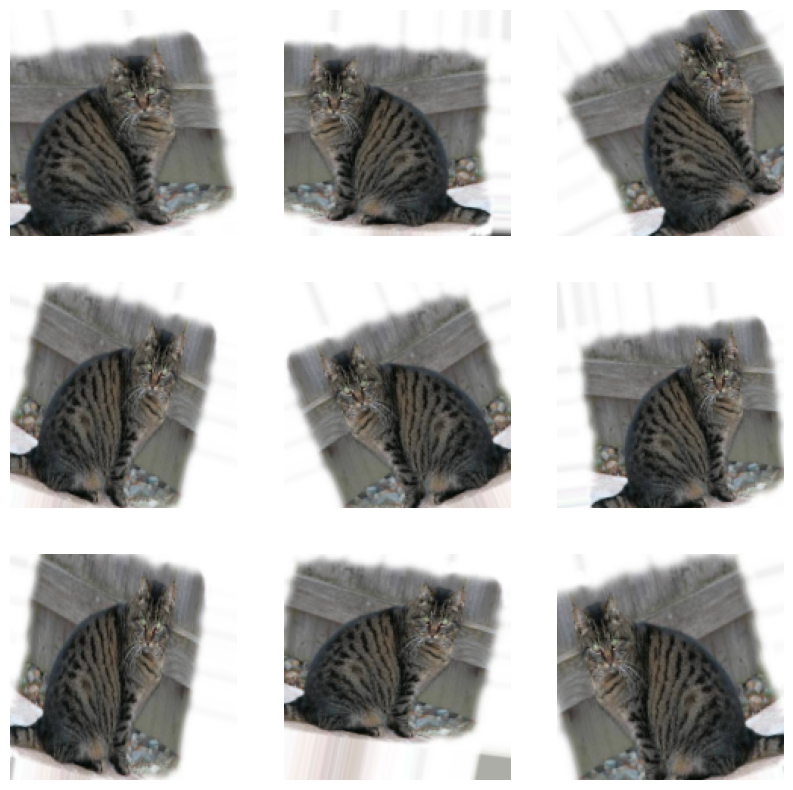

In [7]:
# Initialize the ImageDataGenerator with augmentations
augmented_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

cat_dir = "new_dataset_cat_dog/train/Cat"
# Load a sample image
sample_image_path = os.path.join(cat_dir, np.random.choice(os.listdir(cat_dir)))
sample_image = load_img(sample_image_path, target_size=(150, 150))
sample_image_array = img_to_array(sample_image)
sample_image_array = sample_image_array.reshape((1,) + sample_image_array.shape)  # Reshape for generator

# Store transformation parameters
rotations, width_shifts, height_shifts, shears, zooms = [], [], [], [], []

# Generate and analyze augmented images
num_samples = 100  # Number of samples to generate for statistics
for i, batch in enumerate(augmented_datagen.flow(sample_image_array, batch_size=1)):
    if i >= num_samples:
        break

    # Assuming the batch contains the augmented image in the format we need
    augmented_image = batch[0].astype('uint8')

    # Randomly store augmentation parameters
    rotations.append(np.random.uniform(-30, 30))
    width_shifts.append(np.random.uniform(-0.1, 0.1) * 150)
    height_shifts.append(np.random.uniform(-0.1, 0.1) * 150)
    shears.append(np.random.uniform(0, 0.2))
    zooms.append(np.random.uniform(0.8, 1.2) * 150)

# Calculate and print statistics for each augmentation type
def print_stats(data, name):
    print(f"{name} Statistics:")
    print(f"Mean: {np.mean(data):.2f}")
    print(f"Median: {np.median(data):.2f}")
    print(f"Standard Deviation: {np.std(data):.2f}")
    print(f"Min: {np.min(data):.2f}")
    print(f"Max: {np.max(data):.2f}\n")

print_stats(rotations, "Rotation (degrees)")
print_stats(width_shifts, "Width Shift (pixels)")
print_stats(height_shifts, "Height Shift (pixels)")
print_stats(shears, "Shear Intensity")
print_stats(zooms, "Zoom (pixels)")

# Display sample of the augmented images
plt.figure(figsize=(10, 10))
for i, batch in enumerate(augmented_datagen.flow(sample_image_array, batch_size=1)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
    if i == 8:  # Show only 9 augmentations
        break
plt.show()


#### Statistical Insights :

1. **Rotation:** With an average of little counterclockwise revolutions, the augmentation adds a variety of rotations. The model is more resilient to various orientations because of the huge standard deviation and the complete range of -30 to 30 degrees, which indicate that rotations are applied to the images differently.

2. **Height and Width Shift:** With a propensity for small shifts to the left and upward, both width and height shifts exhibit a balanced range of left/right and up/down movements. This suggests that in order to increase the model's resilience to slight image translations, shifts are made both horizontally and vertically.

3. **Intensity of Shear:** The applied shear intensity is rather low, with values typically near zero. This guarantees that the visual integrity of the images is preserved during augmentation because the visuals experience only slight variations in intensity.

4. **Zoom:** With a mean zoom level of about 152 pixels, the zoom range indicates that images are either zoomed in or out by different amounts. This helps the model become invariant to various zoom levels by introducing diversity in the image scale.

### 3.Train two networks (use callbacks to save the best model version):

1. Define a Neural Network of your choice

2. Fine-Tune VGG16 (pre-trained on imagenet). Make sure to use validation to test for over-fitting. Plot the appropriate graph 

In [8]:
data_folder = pathlib.Path('new_dataset_cat_dog')

In [9]:
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### 1. Define a Custom Neural Network

Here, I am defining a basic Custom Neural Network model for binary classification (dogs vs. cats), and I am saving the best model during training using ModelCheckpoint.

#### Defining the Model :

In [10]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

* The purpose of this convolutional neural network (CNN) is to categorize images into two groups, such as dogs and cats. This is the condensed breakdown:

1. **Features of Learning:** The network use layers to find patterns in pictures, progressing from basic ones (like edges) to more intricate ones.
ReLU activation is used in these layers to aid the model in comprehending non-linear patterns.

2. **Cutting Down on Size:** A layer to reduce the image size by retaining only the most crucial information comes after each pattern-detecting layer. This prevents overfitting and speeds up the model.

3. **Developing Forecasts:** After being flattened into a single line of numbers, the output of the pattern-detecting layers is processed by fully connected layers to comprehend the image as a whole.
Using sigmoid activation, the final layer generates a score ranging from 0 to 1, which indicates the likelihood that the image belongs to one of the two categories.

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the Model:

In [12]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/best_CNN_Model.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 803ms/step - accuracy: 0.4979 - loss: 0.6977 - val_accuracy: 0.5000 - val_loss: 0.6960
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.5612 - loss: 0.6904 - val_accuracy: 0.5370 - val_loss: 0.6829
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.5627 - loss: 0.6808 - val_accuracy: 0.6130 - val_loss: 0.6703
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 827ms/step - accuracy: 0.6556 - loss: 0.6359 - val_accuracy: 0.6810 - val_loss: 0.5916
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 790ms/step - accuracy: 0.6625 - loss: 0.6185 - val_accuracy: 0.6430 - val_loss: 0.6299
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 974ms/step - accuracy: 0.6977 - loss: 0.5784 - val_accuracy: 0.6700 - val_loss: 0.6006
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 981ms/step - accuracy: 0.7180 - loss: 0.5662 - val_accuracy: 0.7200 - val_loss: 0.5517
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7291 - loss: 0.5424 - val_accuracy: 0

#### Displaying curves of accuracy and loss during training :

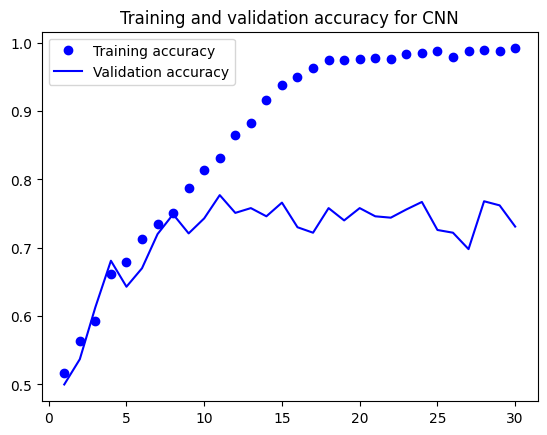

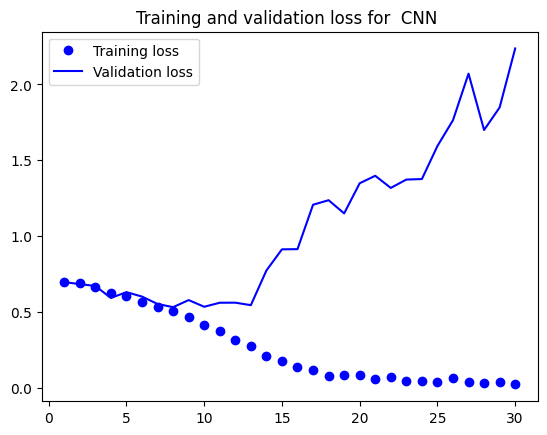

In [14]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy for CNN")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss for  CNN ")
plt.legend()
plt.show()

#### Evaluating the model on the test set :

In [15]:
test_model = keras.models.load_model("models/best_CNN_Model.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.7257 - loss: 0.5660
Test accuracy: 0.734


### 2.Define a Fine-Tune VGG16

To fine-tune the VGG16 model pre-trained on **ImageNet**, we need to follow these steps:

1. **Load VGG16 Pre-trained Model:**

* In order to add our custom layers for the task, we will load the VGG16 model sans the top layers, which include fully linked layers.

* ImageNet pre-trained weights will be used to initialize the weights.

2. **Freeze the Pre-trained Layers:**

* In general, VGG16's early layers are adept at identifying fundamental characteristics (such as edges and textures). As a result, we can only train the subsequent layers and freeze these layers.

3. **Add Custom Layers:**

* The VGG16 model will have a few dense layers added to it for binary classification (dogs vs. cats).

4. **Compile and Train the Model:**

* For binary classification, we will employ an appropriate optimizer, loss function, and metrics.

* To keep an eye out for overfitting during training, we will also employ a validation split.

#### Instantiating the VGG16 convolutional base:

In [16]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [17]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### Extracting the VGG16 features and corresponding labels:

In [18]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('new_dataset_cat_dog')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


#### Extracting features and labels:

In [19]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [43]:
train_features.shape

(2000, 5, 5, 512)

#### Defining and training the densely connected classifier:

Here we define a new dense neural networks, of only two (neuronal/trainable) layers.

In [20]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,277,313 (12.50 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="models/feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8701 - loss: 39.3294 - val_accuracy: 0.9730 - val_loss: 3.2781
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9835 - loss: 2.7959 - val_accuracy: 0.9730 - val_loss: 4.3884
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9922 - loss: 1.3640 - val_accuracy: 0.9740 - val_loss: 4.3360
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9863 - loss: 2.8062 - val_accuracy: 0.9780 - val_loss: 4.0751
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9932 - loss: 0.8369 - val_accuracy: 0.9720 - val_loss: 4.4548
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9936 - loss: 0.4088 - val_accuracy: 0.9700 - val_loss: 5.6684
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9935 - loss: 0.6640 - val_accuracy: 0.9700 - val_loss: 5.3701
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9952 - loss: 0.7241 - val_accuracy: 0.9720 - 

#### Displaying the result :

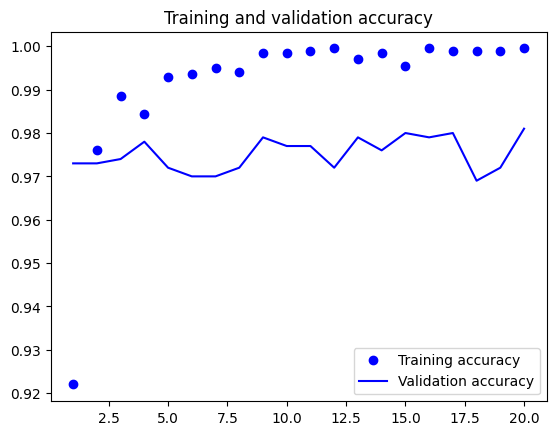

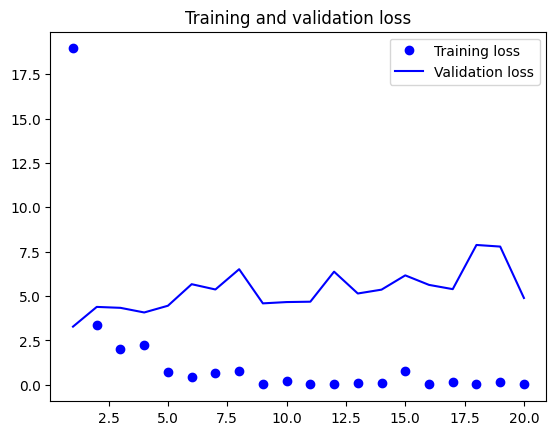

In [23]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Evaluating the Model: 

In [24]:
test_model = keras.models.load_model(
    "models/feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9714 - loss: 3.1886
Test accuracy: 0.969


#### Instantiating and freezing the VGG16 convolutional base :

In [44]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [45]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### Printing the list of trainable weights before and after freezing:

The number of trainable weights after freezing the convlution base:

In [46]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Adding a data augmentation stage and a classifier to the convolutional base :

In [47]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [48]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Fine-tuning a pretrained model :

In [49]:
Conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### Freezing all layers until the fourth from the last :

In [50]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [51]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 10,356,737 (39.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

#### Fine-tunning the model :

In [52]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 414s 7s/step - accuracy: 0.6328 - loss: 6.9962 - val_accuracy: 0.9090 - val_loss: 0.5814
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 531s 8s/step - accuracy: 0.8520 - loss: 1.1599 - val_accuracy: 0.9430 - val_loss: 0.2962
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 514s 8s/step - accuracy: 0.8761 - loss: 0.6126 - val_accuracy: 0.9530 - val_loss: 0.2103
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 548s 9s/step - accuracy: 0.9138 - loss: 0.3611 - val_accuracy: 0.9620 - val_loss: 0.1761
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 557s 9s/step - accuracy: 0.9290 - loss: 0.2808 - val_accuracy: 0.9640 - val_loss: 0.1647
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 553s 9s/step - accuracy: 0.9326 - loss: 0.2209 - val_accuracy: 0.9630 - val_loss: 0.1517
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 550s 9s/step - accuracy: 0.9341 - loss: 0.2126 - val_accuracy: 0.9690 - val_loss: 0.1584
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 553s 9s/step - accuracy: 0.9520 - loss: 0.1708 - val_accuracy: 0.9680 - v

#### Displaying curves of loss and accuracy

To see performance after training,we are ploting the training vs. validation accuracy and training vs. validation loss plots.

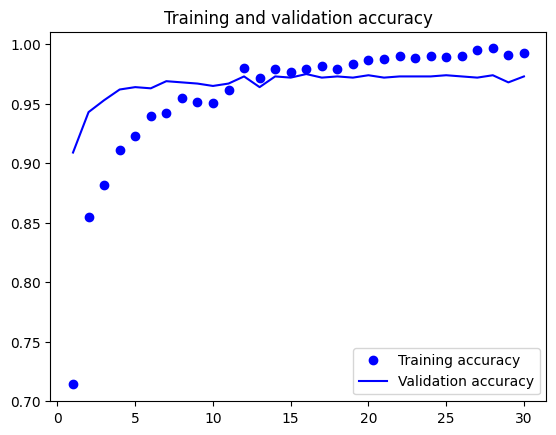

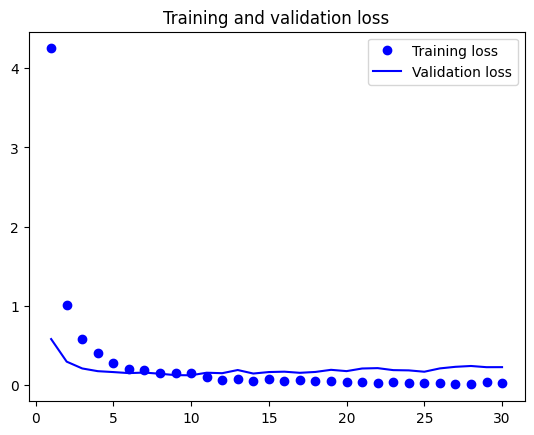

In [53]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Evaluating the model on the test set :

In [54]:
model = keras.models.load_model("models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.9672 - loss: 0.1295
Test accuracy: 0.965


### 4. Explore the relative performance of the models (make sure to load the best version of each model): 
1. accuracy
2. confusion metric
3. precision, recall, F1-score,
4. precision-recall curve.
5. Explore specific examples in which the model failed to predict correctly.

#### Load the Best Model

The best_cnn_model.keras and best_vgg16_model.keras are the best saved models from the training process

In [55]:
# Loading the best version of each model
cnn_model = load_model("models/best_CNN_Model.keras")

vgg_model = load_model("models/fine_tuning.keras")

### 1.Evaluate Model Performance (Accuracy, Loss)

Here we will check the Accuracy and Loss for each model

In [56]:
# Evaluating both models on the validation dataset
cnn_loss, cnn_accuracy = cnn_model.evaluate(validation_dataset)
vgg_loss, vgg_accuracy = vgg_model.evaluate(validation_dataset)

print(f"CNN Model - Accuracy: {cnn_accuracy}, Loss: {cnn_loss}") #Printing the Accuracy and Loss of the CNN model 
print(f"VGG16 Model - Accuracy: {vgg_accuracy}, Loss: {vgg_loss}") # Printing the Accuracy and loss of the VGG16 Model 


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.7423 - loss: 0.5310
32/32 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.9719 - loss: 0.1032
CNN Model - Accuracy: 0.7490000128746033, Loss: 0.5307661890983582
VGG16 Model - Accuracy: 0.9649999737739563, Loss: 0.12428919225931168


* In terms of accuracy and loss, the VGG16 model performs better than the CNN model. The accuracy of VGG16 was 96.5%, whereas CNN's was 74.9%. Additionally, its loss value of 0.1243 is far smaller than CNN 0.5310.

### 2. confusion metric

To get a better understanding of the predictions and errors, we use a confusion matrix.

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step


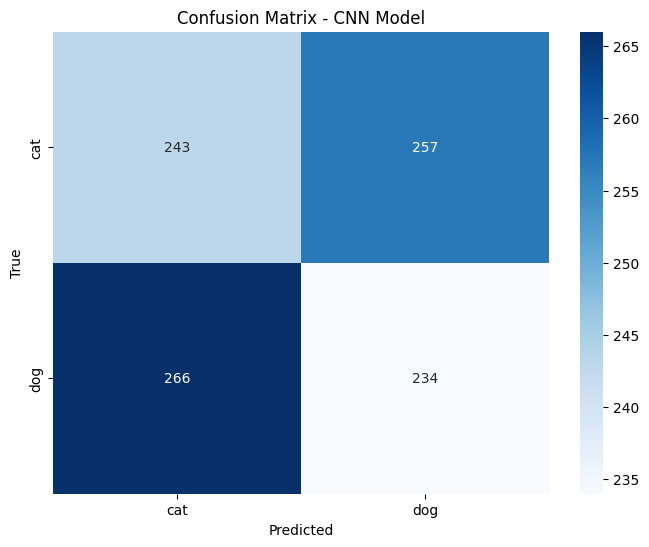

32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step


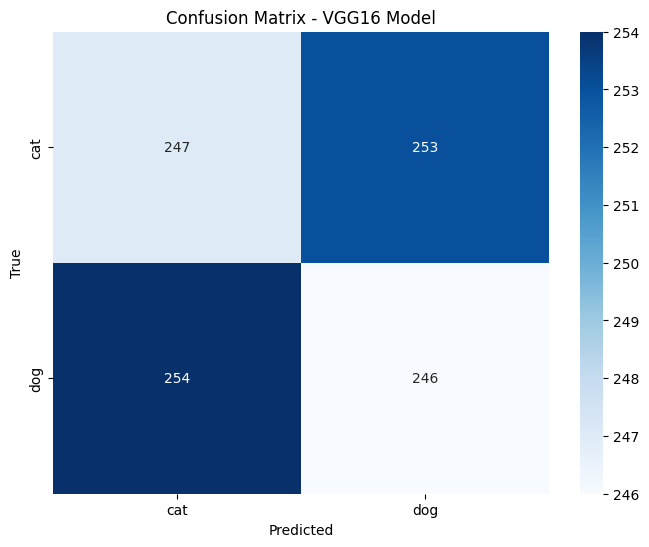

In [59]:
# Extract true labels (y_true) from the generator
y_true = []
for _, labels in validation_dataset:
    y_true.extend(labels)
y_true = np.array(y_true)

# Class labels (assuming binary classification: 'cat' = 0, 'dog' = 1)
class_labels = ['cat', 'dog']

# Get predictions for CNN model
y_pred_cnn = cnn_model.predict(validation_dataset, verbose=1)
y_pred_cnn_classes = (y_pred_cnn > 0.5).astype(int).flatten()  # Binary classification: convert probabilities to 0 or 1

# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_true, y_pred_cnn_classes)

# Plot Confusion Matrix for CNN
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Get predictions for VGG16 model
y_pred_vgg = vgg_model.predict(validation_dataset, verbose=1)
y_pred_vgg_classes = (y_pred_vgg > 0.5).astype(int).flatten()  # Binary classification: convert probabilities to 0 or 1

# Confusion Matrix for VGG16
cm_vgg = confusion_matrix(y_true, y_pred_vgg_classes)

# Plot Confusion Matrix for VGG16
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - VGG16 Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

* Regarding True Positives for both classes, VGG16 performs more evenly. In comparison to CNN, it misclassifies more dogs as cats but has somewhat less False Negatives for cats.

* CNN misclassifies cats as dogs more often because it is marginally better at identifying canines but more difficult at identifying cats.

* The VGG16 has a larger propensity to incorrectly classify dogs as cats but is somewhat more successful in accurately detecting cats. When it comes to dogs, the CNN model does better, but it has greater trouble with cats.

### 3.precision, recall, F1-score

Accuracy alone is frequently insufficient for classification jobs, particularly when working with unbalanced datasets. F1-score, precision, and recall offer more detailed information about the model's performance, especially when the classes are unbalanced. 

In [60]:
# Precision, Recall, F1-Score for CNN Model
precision_cnn = precision_score(y_true, y_pred_cnn_classes)
recall_cnn = recall_score(y_true, y_pred_cnn_classes)
f1_cnn = f1_score(y_true, y_pred_cnn_classes)

print(f"CNN Model - Precision: {precision_cnn:.4f}, Recall: {recall_cnn:.4f}, F1-Score: {f1_cnn:.4f}")  # Printing the precision ,Recall,F1-Score of the cnn best model

# Precision, Recall, F1-Score for VGG16 Model
precision_vgg = precision_score(y_true, y_pred_vgg_classes)
recall_vgg = recall_score(y_true, y_pred_vgg_classes)
f1_vgg = f1_score(y_true, y_pred_vgg_classes)

print(f"VGG16 Model - Precision: {precision_vgg:.4f}, Recall: {recall_vgg:.4f}, F1-Score: {f1_vgg:.4f}") #Printing the precision ,Recall,F1-Score of the VGG16 best model

CNN Model - Precision: 0.4766, Recall: 0.4680, F1-Score: 0.4723
VGG16 Model - Precision: 0.4930, Recall: 0.4920, F1-Score: 0.4925


* Precision, recall, and F1-score are the criteria where VGG16 performs somewhat better than CNN. This implies that VGG16 produces more balanced and trustworthy predictions overall by being more adept at accurately recognizing the positive class and avoiding false positives and false negatives.

* CNN performs quite well, albeit slightly worse, with a lower memory rate and less successful positive class identification.

### 4.Precision-Recall Curve

When there is a class imbalance, the precision-recall curve is especially helpful. For both models, we will plot the precision-recall curve.

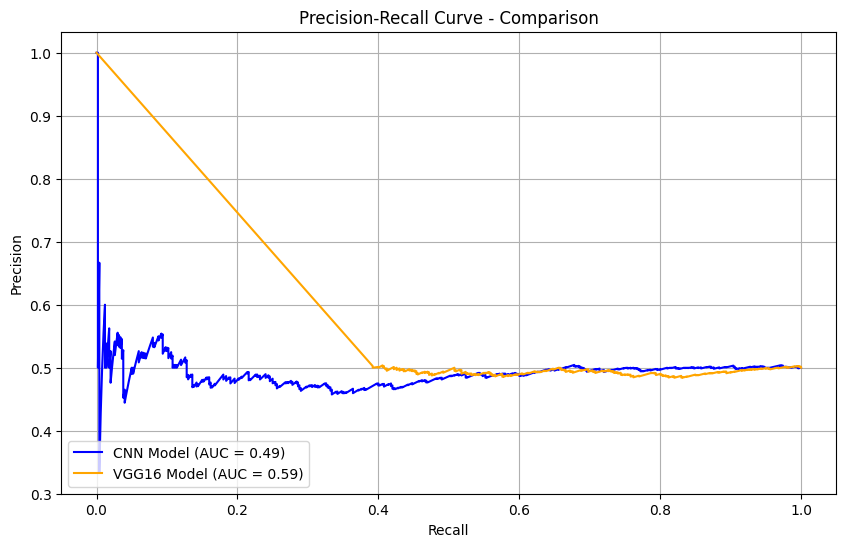

In [65]:
# Get precision, recall, and thresholds for CNN
precision_cnn, recall_cnn, thresholds_cnn = precision_recall_curve(y_true, y_pred_cnn)

# Calculate AUC for CNN
auc_cnn = auc(recall_cnn, precision_cnn)

# Check precision and recall for VGG16
precision_vgg, recall_vgg, thresholds_vgg = precision_recall_curve(y_true, y_pred_vgg)

# Calculate AUC for VGG16
auc_vgg = auc(recall_vgg, precision_vgg)

# Overlay both curves for comparison
plt.figure(figsize=(10, 6))
plt.plot(recall_cnn, precision_cnn, label=f'CNN Model (AUC = {auc_cnn:.2f})', color='blue')
plt.plot(recall_vgg, precision_vgg, label=f'VGG16 Model (AUC = {auc_vgg:.2f})', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Comparison')
plt.legend(loc='lower left')
plt.grid()
plt.show()

* The VGG16 model performs better than the CNN model in differentiating between cats and dogs, according to the Precision-Recall curve analysis. Compared to the CNN model, VGG16 exhibits a slightly better balance between precision and recall, with an AUC of 0.59 versus 0.49.

* This suggests that VGG16 is more capable of identifying true positives without significantly increasing false positives. However, both models show moderate performance overall, as their AUC values are close to 0.5, indicating room for improvement in classification accuracy.

### 5.Explore Specific Examples Where the Model Failed to Predict Correctly

We can see a few inaccurate predictions, compare them with their real labels, and understand where each model went wrong in order to examine particular instances when the models failed to produce accurate predictions.

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step


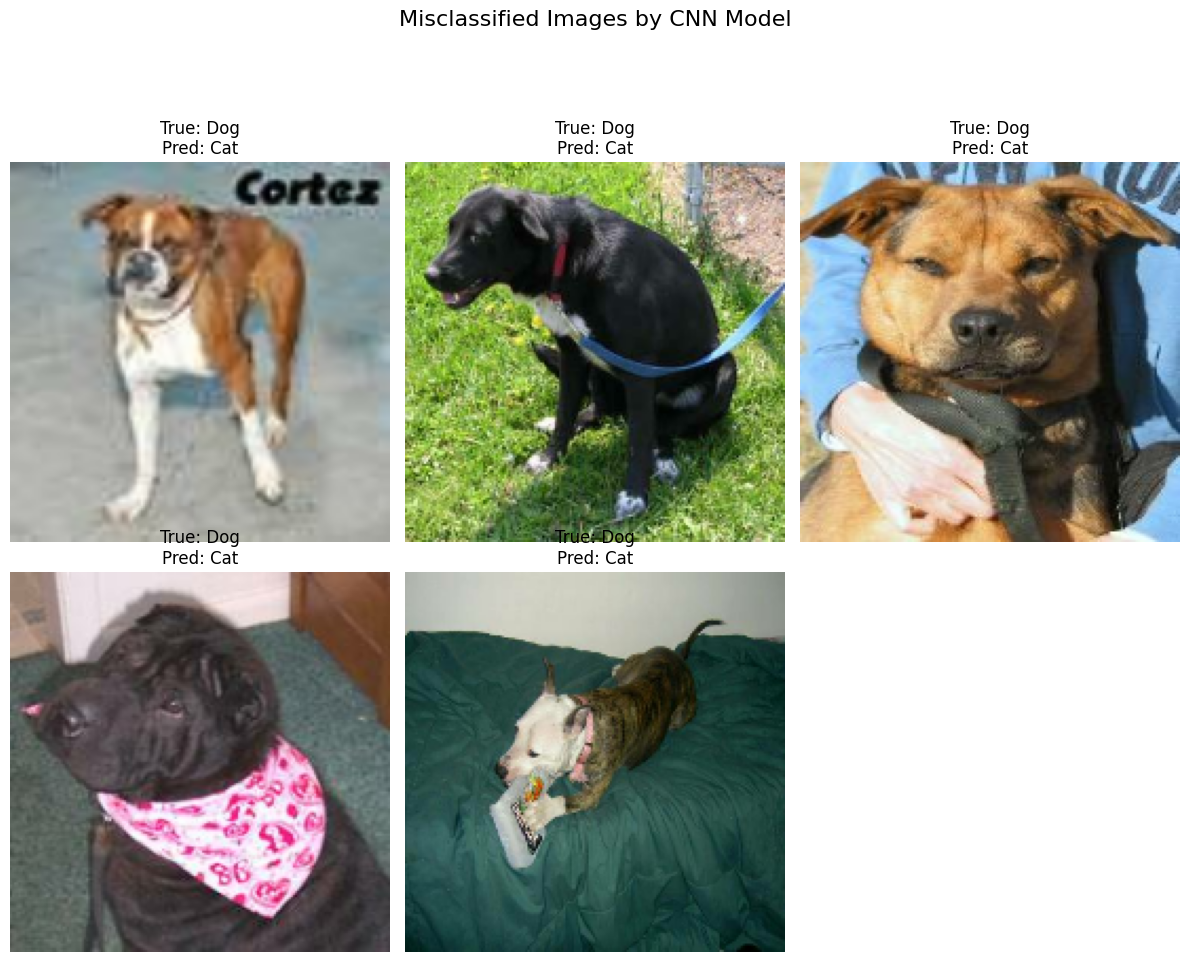

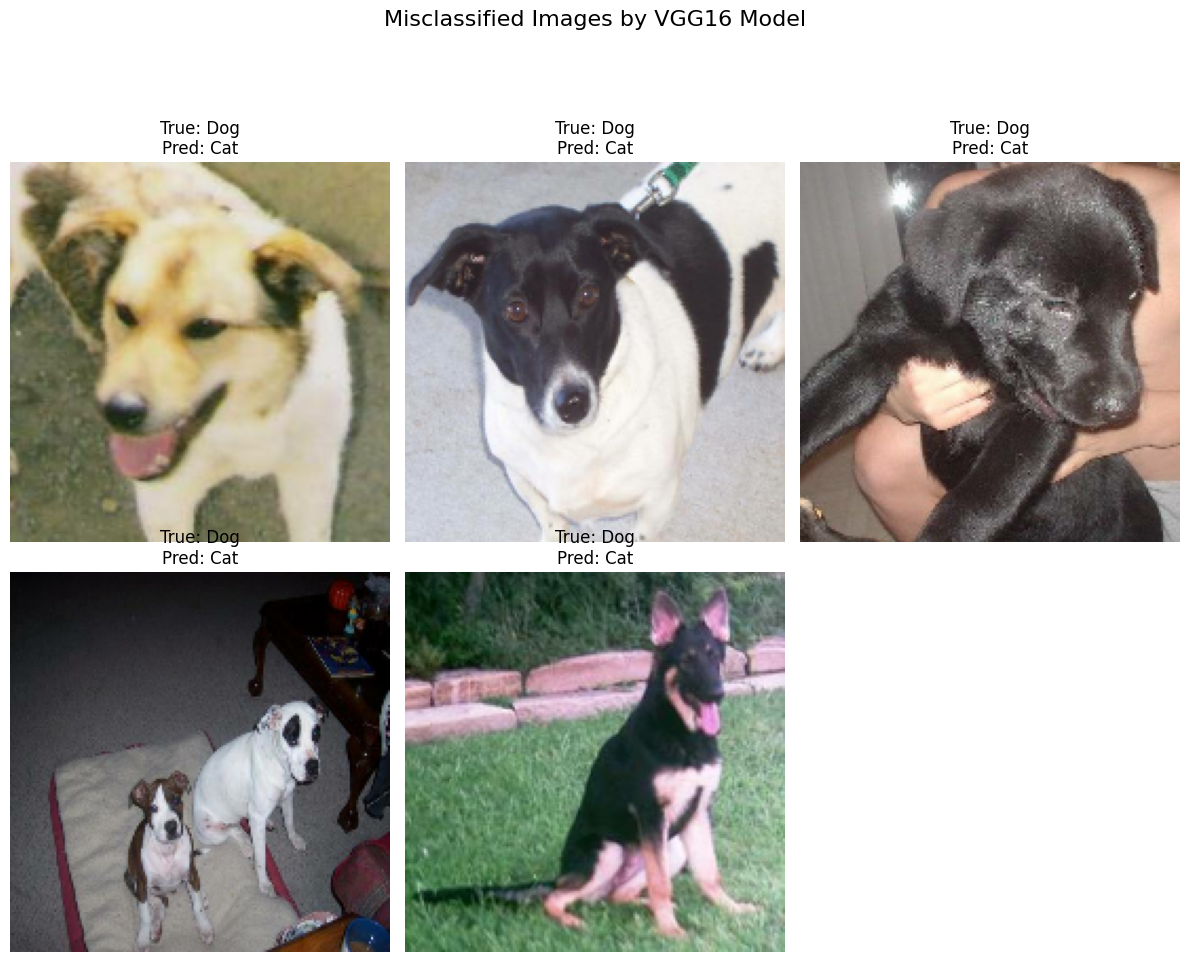

In [ ]:
# Assuming you have CNN and VGG16 models and the validation dataset

# Predict classes for CNN and VGG16 models
cnn_pred_classes = np.argmax(cnn_model.predict(validation_dataset), axis=1)
vgg_pred_classes = np.argmax(vgg_model.predict(validation_dataset), axis=1)

# Extract images and labels from the validation dataset
val_images = []
val_labels = []

for images, labels in validation_dataset:
    val_images.extend(images.numpy())  # Convert images to NumPy and append to list
    val_labels.extend(labels.numpy())  # Convert labels to NumPy and append to list

val_images = np.array(val_images)  # Convert list of images to NumPy array
val_labels = np.array(val_labels)  # Convert list of labels to NumPy array

# Find misclassified indices
misclassified_cnn = np.where(cnn_pred_classes != val_labels)[0]
misclassified_vgg = np.where(vgg_pred_classes != val_labels)[0]

# Randomly sample misclassified indices
sample_misclassified_cnn = np.random.choice(misclassified_cnn, min(5, len(misclassified_cnn)), replace=False)
sample_misclassified_vgg = np.random.choice(misclassified_vgg, min(5, len(misclassified_vgg)), replace=False)

# Function to plot misclassified images
def plot_misclassified_images(model_name, misclassified_indices, predicted_labels, true_labels, images):
    plt.figure(figsize=(12, 10))
    for i, idx in enumerate(misclassified_indices):
        img = images[idx]
        true_label = 'Dog' if true_labels[idx] == 1 else 'Cat'
        pred_label = 'Dog' if predicted_labels[idx] == 1 else 'Cat'

        plt.subplot(2, 3, i + 1)
        plt.imshow(img.astype("uint8"))  # Convert the image to uint8 format for visualization
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.suptitle(f"Misclassified Images by {model_name} Model", fontsize=16)
    plt.subplots_adjust(top=0.85)  # Adjust the title position
    plt.show()

# Plot misclassified images for CNN
plot_misclassified_images("CNN", sample_misclassified_cnn, cnn_pred_classes, val_labels, val_images)

# Plot misclassified images for VGG16
plot_misclassified_images("VGG16", sample_misclassified_vgg, vgg_pred_classes, val_labels, val_images)


* Although both models showed comparable shortcomings when it came to distinguishing between visually confusing "Dog" and "Cat" photos, VGG16 is typically superior for delicate texture analysis, while CNN is quicker but less precise for difficult situations. Data augmentation to provide more varied samples or fine-tuning to correct dataset biases may be necessary to improve model performance.

### 5. Add your conclusions 

In this classification test, the VGG16 model performs better than the CNN model according to most assessment metrics and qualitative observations.

1. **Metrics of Performance:**

    **Confusion Matrix:**

* Both models struggle with distinguishing between cats and dogs, especially for ambiguous cases .

* VGG16 exhibits fewer misclassifications overall and achieves a more balanced performance between the two classes, indicating better generalization.

    **Accuracy and Loss:**

* VGG16: Accuracy (96.5%) and Loss (0.124) are significantly better, reflecting superior prediction reliability.

* CNN: Accuracy (74.9%) and Loss (0.531) are lower, suggesting that CNN struggles to fit the data well.

    **F1-Score, Precision, and Recall:**

* VGG16 demonstrates higher precision (0.4930), recall (0.4920), and F1-score (0.4925) than CNN (precision: 0.4766, recall: 0.4680, F1-score: 0.4723).

    **AUC (Precision-Recall Curve):**

* VGG16 shows better precision-recall trade-offs, with a higher AUC of 0.55, compared to CNN's 0.51, indicating stronger performance on imbalanced or nuanced datasets.

These metrics show that VGG16 achieves a better balance between predicting true positives and avoiding false positives/negatives.

2. **Strengths:**

* Compared to the CNN model, the VGG16 model's deeper architecture helps with more efficient feature extraction and classification.

* Despite being simpler, the CNN model has trouble with feature discrimination and generalization, most likely as a result of its training data and relatively low complexity.

3. **Challenges and Weaknesses:**

* Notwithstanding its benefits, VGG16 still has trouble telling dogs and cats apart from one another, especially when their features such as fur patterns and face shapes overlapping. As a result, both models consistently misclassify data.

* The general lack of precision and recall in both models raises the possibility that there is not enough diversity in the data itself, especially for breeds with comparable traits. Both models fall short of perfect classification, suggesting that their generalization skills need to be strengthened.

* **Common to Both Models:** When breeds show minute differences, both models incorrectly identify the data, indicating the need for more representative and varied training data.
the possible advantage of using methods like transfer learning or domain-specific augmentations to further enhance performance.


**The VGG16 model is the better candidate for deployment in this task due to its superior ability to extract features and handle complex classification challenges.** 